# CIFAR10 - Deep learning techniques 적용하기

### 과제 - 심화
``` plainText
- Dataset 및 activation 함수 변경
  MNIST -> CIFAR10
  ReLU -> LeakyReLU
  epoch=50, batch_size=256

- CIFAR10 input shape 확인
  MNIST와 다른 input shape

- SGD vs Adam 성능 비교
  1. Adam optimizer
  2. SGD optimizer
  3. epoch에 따른 train accuracy plot (Plot 1)

- LeakyReLU vs Sigmoid 성능 비교
  1. nn.Sigmoid class 정의
  2. Adam optimizer 기반 LeakyReLu, Sigmoid 학습
  3. epoch에 따른 train accuracy plot (Plot 2)

- Dropout 적용한 이후의 generalization error 확인
  1. Dropout을 LeakyReLU 사용하는 MLP의 모든 layer에 적용한 class 새로 정의
  2. Dropout 확률 0.1
  3. model.train() 사용
  4. with torch.no_grad():
      model.eval() 적용
  5. Adam Optimizer로 Dropout 적용 모델 학습 후 epoch에 따른 train/test accuracy 비교 (Plot 3)

```

### CIFAR10 데이터셋 가져오기
- MNIST 데이터를 가져올 때와 다르게 import 부분에서 데이터셋을 바로 가져옴
- import torchvision.transforms as transforms 라는 코드는 불편해서 수정
- CIFAR10 : 32 * 32 colour images in 10 classes
- 총 6만 개(5만 개의 train data / 1만 개의 test data)
![CIFAR10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np

In [2]:
# 공통 하이퍼 파라미터 선언
batch_size = 256
n_epochs = 50
learning_rate = 0.001

# device 선언 - 코랩도 GPU 로드 안되는 경우 발생
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Dataset 준비

In [3]:
transform = transforms.ToTensor()

# CIFAR10 데이터셋 불러오기
trainset = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Dataloader 정의
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

### 가져온 Dataset 확인해보기
- train/test 데이터 갯수 확인
- input label 셋 확인
- 시각화 이미지도 한 번 확인해보기   
  RGB 이미지로 3차원 이미지: cmap 설정 불필요   
  MNIST는 Grayscale로 1차원 이미지였다
- label 값이 숫자로 나오는데, 하단 이미지 label 처럼 string으로 받고 싶은 경우 class 리스트를 가져와서 매핑해주면 된다
  
### CIFAR10 처음 25장 이미지
![CIFAR10 first 25 images](https://www.researchgate.net/publication/378435489/figure/fig1/AS:11431281225494651@1708735997293/The-first-25-images-in-cifar-10.png)

### PyTorch 텐서 구조 vs matplotlib의 이미지 인식 방식

``` python
# PyTorch에서 image를 읽을 때
MNIST -> image.shape: torch.Size([1, 28, 28])
CIFAR10 -> image.shape: torchSize([3, 32, 32])

=> [Channel, Height, Width] 구조: CHW(C-H-W)

# matplotlib.pyplot.imshow()가 기대하는 형태
[Height, Width, Channels] 구조: HWC

HWC 형태여야 RGB 컬러 이미지를 제대로 해석할 수 있다

# Error Message
TypeError: Invalid shape (3, 32, 32) for image data

실제로, 텐서 배열의 순서를 HWC 구조로 바꿔주지 않으면 위 처럼 TypeError가 발생한다
```

### 채널
``` plainText
3차원 RGB 이미지를 시각화하려니 1차원 흑백 이미지와 방식이 좀 상이해서 찾아봤다
```
**어, MNIST 때에는 이런 작업 안해줬던 것 같은데...🤔**

``` python
# 각각의 채널이 존재하고, 그에 대한 픽셀 값들을 2D 배열로 저장

# RGB 3채널 이미지 채널 구조
# image.shape -> [3, 32, 32]
1️⃣ R (Red)  
2️⃣ G (Green)  
3️⃣ B (Blue)

# 흑백 이미지 채널 구조
image.shape -> [1, 28, 28]
1️⃣ 밝기 정보 하나만 존재
```

이렇다보니, MNIST 시각화에서는 아래와 같이 첫번째 채널을 꺼내서 시각화를 해도 되는 것
``` python
# 어차피 채널 하나
# 그 채널 하나가 이미지 정보를 다 갖고 있음
plt.imgshow(image[0].shape, cmap='gray')

# 추가적으로 알 것
# 결과는 같으나, 의미가 다르다
x.squeeze().shape -> [28, 28]   # 크기가 1인 모든 채널 제거
x[0].shape -> [28, 28]          # 첫 번째 채널 하나만 꺼내오는 것
```

**그와 별개로 CIFAR10은 RGB 3채널 이미지이다 보니, MNIST처럼 시각화하면, 이미지 정보가 전부 존재하지 않아 이미지가 깨지거나 오류가 날 수 있다**


50000
torch.Size([3, 32, 32])
TRAIN | class index: 1 | real class: automobile
10000
torch.Size([3, 32, 32])
TEST | class index: 7 | real class: horse


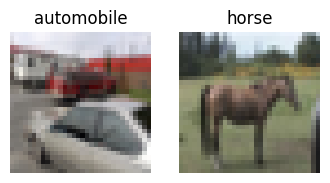

In [4]:
from matplotlib import pyplot as plt

# train/test data 크기가 다르기에 index 따로 정의
index = 49999
index_test = 9999

# 이미지, 라벨 추출
image, label = trainset[index][0], trainset[index][1]
image_test, label_test = testset[index_test][0], testset[index_test][1]

# permute()를 통해 채널 값을 가장 마지막으로 보내서 image 텐서를 조작
image_np = image.permute(1,2,0)
image_test_np = image_test.permute(1,2,0)

# 숫자값이 아닌 실제 이미지에 맞는 label을 받아보고싶다
# 어떤 class를 가지고 있는지 알 수 있다
class_names = trainset.classes

# 이미지를 여러개 보고 싶어서 subplots 처리
# 가로 4인치 * 세로 2인치 캔버스에 1행 2열 grid 이미지 배
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))

# TRAIN
print(len(trainset))
print(image.shape)
print(f'TRAIN | class index: {label} | real class: {class_names[label]}')
ax1.set_title(class_names[label])
ax1.imshow(image_np)
ax1.axis('off')

# TEST
print(len(testset))
print(image_test.shape)
print(f'TEST | class index: {label_test} | real class: {class_names[label_test]}')
ax2.set_title(class_names[label_test])
ax2.imshow(image_test_np)
ax2.axis('off')

plt.show()

### Input Shape 확인

In [5]:
images, labels = next(iter(trainloader))
print(f'훈련용 데이터: {images.shape, labels.shape}')

testImages, testLabels = next(iter(testloader))
print(f'테스트용 데이터: {testImages.shape, testLabels.shape}')

훈련용 데이터: (torch.Size([256, 3, 32, 32]), torch.Size([256]))
테스트용 데이터: (torch.Size([256, 3, 32, 32]), torch.Size([256]))


### ReLU vs LeakyReLU

**ReLU (Rectified Linear Unit)**   
- f(x)=max(0,x)
- x >= 0일 때 gradient가 일정하게 흐르기에 학습이 빠름
- ❌ **dying ReLU**
  - 학습 간, x < 0 영역에 일부 뉴런이 머무를 때
  - output, gradient 모두 계속 0 => 죽어버리는 현상
  - 다시 업데이트가 안됨

**LeakyReLU (Leaky Rectified Linear Unit)**
- f(x)=max(αx,x) -> (보통 α=0.01)
- ReLU와 다르게 negative_slope 값을 통해 x < 0일 때 small gradient로 값을 출력
- x >= 0일 때 ReLU와 동일
- ✅**Not dying** -> x < 0 영역에서 지속적으로 정보 전달이 가능해짐
  - ReLU의 dying ReLU 보완

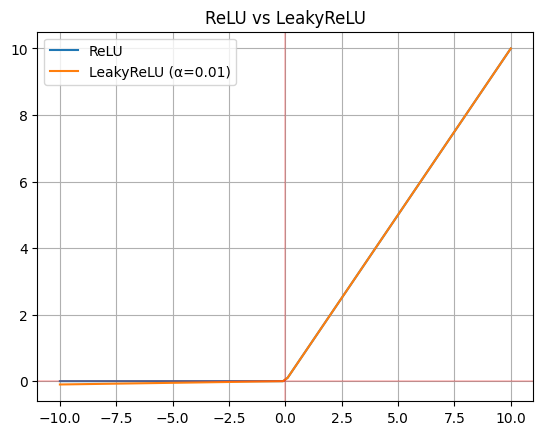

In [6]:
from torch import nn
# 간단하게 그래프 비교해보고 가기

# x축을 -10 ~ 10 까지를 100눈금으로 나누어서 설정
x = torch.linspace(-10, 10, 100)

# ReLU 함수
relu_fn = nn.ReLU()
relu = relu_fn(x)
# LeakyReLU 함수
leaky_fn = nn.LeakyReLU(negative_slope=0.01)
leaky = leaky_fn(x)

# PyTorch Tensor -> Numpy ndarray
plt.plot(x.numpy(), relu.numpy(), label='ReLU')
plt.plot(x.numpy(), leaky.numpy(), label='LeakyReLU (α=0.01)')

# 원점 분기로 나뉘는 것 시각화를 위해 추가
plt.axhline(0, color='red', linewidth=0.3)
plt.axvline(0, color='red', linewidth=0.3)

plt.title("ReLU vs LeakyReLU")
plt.legend()
plt.grid(True)
plt.show()


### Model 정의

flatten() vs view()
- CNN 등의 입력 텐서를 MLP 레이어에 넣기 전에 flatten 하는 작업
- ex> CIFAR10 이미지 [batch, 3, 32, 32] -> [batch, 3072]

``` python
1️⃣x = torch.flatten(x, start_dim=1)
  # start_dim=1 부터 끝까지 flatten
  # batch 유지, 나머지 1D으로
  # 명확, 직관적, 다차원에도 유연(start_dim 지정)


2️⃣x = x.view(x.size(0), -1)
  # -1: PyTorch가 알아서 계산하라는 뜻
  # batch 유지(x.size(0))
  # 자주 쓰는 방식
  
  # But
  # 텐서가 contiguous(연속적)한 경우에만 동작함 -> view() 전에 .contiguous()붙여야 하는 경우가 있음
```

=> **직관적인게 좋아서 flatten 씁니다**

In [7]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    # 활성화 함수 ReLU -> LeakyReLU 변경
    self.act = nn.LeakyReLU(negative_slope=0.01)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

# numel() 함수 사용 - shape의 모든 성분 곱한 값: 전체 차원 수
# 맨날 곱해줘야하나 싶어서 찾아보니 함수가 역시 있다

### Optimizer 선언 - Adam vs SGD

In [8]:
from torch.optim import Adam, SGD

model_adam = Model(image.numel(), 1024).to(device)
model_sgd = Model(image.numel(), 1024).to(device)

optimizer_Adam = Adam(model_adam.parameters(), lr=learning_rate)
optimizer_SGD = SGD(model_sgd.parameters(), lr=learning_rate)

### 정확도 측정 함수 선언

**학습 vs 평가**   
- 학습 중 `model.train()`
  - 파라미터 업데이트 용
  - Dropout 활성화 (무작위로 일부 뉴런을 꺼서 regularization 작업)
  - BatchNorm 활성화
    - batch 마다 평균/표준편차 계산
  - Gradient 계산   
- 평가 중 `model.eval()`
  - 학습 없이 정확도 등의 수치 확인
  - Dropout 비활성화 (모든 뉴런 사용)
  - BatchNorm 비활성화
    - 저장된 평균/분산 사용해야함
    - 평가시에는 저장된 moving 평균을 사용해야 정확하게 판단할 수 있음
  - Gradient 계산 안 함: `no_grad`

**no_grad**
- 역전파 안함, gradient 계산이 필요없음
- **PyTorch는 모든 연산에 대해 default로 gradient 추적**을 해서 수동으로 꺼줘야함
  - 안 끄면 메모리 낭비 + 속도 저하

In [9]:
def accuracy(model, dataloader):
  # 평가 중
  model.eval()
  # 직관적으로 변수명 선언
  correct_cnt = 0
  total_cnt = 0

  # 평가 중에는 역전파나 메모리 낭비를 막음
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      # model에 입력을 넣어 logits(예측값)을 받음
      preds = model(inputs)
      # 가장 점수가 높은 클래스 인덱스를 가져옴
      preds = preds.argmax(dim=1)

      # logits == label 총합 텐서 숫자 변환
      correct_cnt += (preds == labels).sum().item()
      total_cnt += labels.size(0)

  return correct_cnt / total_cnt

# 두 훈련 데이터의 정확도를 비교하여 plot 하는 함수
def plot_acc(train1, train2, label1='', label2=''):
  x = np.arange(len(train1))

  plt.plot(x, train1, label=label1)
  plt.plot(x, train2, label=label2)

  # 추가 부분
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.title('Optimizer - Adam vs SGP')

  plt.legend()

  plt.grid(True)
  plt.show()

### Adam / SGD Optimizer 선언

In [10]:
# loss func 선언
loss_fn = nn.CrossEntropyLoss()

# 과제 - 학습/테스트 데이터 담을 곳
train_accs_adam = []
train_accs_sgd = []

def adam(epoch):
  model_adam.train()
  for inputs, labels in trainloader:
      inputs, labels = inputs.to(device), labels.to(device)

      # 바로 전 batch gradient 초기화
      optimizer_Adam.zero_grad()

      preds = model_adam(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer_Adam.step()

  # 정확도 측정 및 데이터 담기
  # 너무 느려서 5 epoch 마다 정확도 평가하도록 - 큰 차이 없어서 그냥 하기로
  train_acc = accuracy(model_adam, trainloader)
  train_accs_adam.append(train_acc)

  print(f"[Adam] Epoch {epoch + 1:2d} | Train Acc: {train_acc: .3f}")

def sgd(epoch):
  model_sgd.train()
  for inputs, labels in trainloader:
      inputs, labels = inputs.to(device), labels.to(device)

      # 바로 전 batch gradient 초기화
      optimizer_SGD.zero_grad()

      preds = model_sgd(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer_SGD.step()

  # 정확도 측정 및 데이터 담기
  train_acc = accuracy(model_sgd, trainloader)
  train_accs_sgd.append(train_acc)
  print(f"[SGD] Epoch {epoch + 1:2d} | Train Acc: {train_acc: .3f}")

### Plot 1 - epoch에 따른 train accuracy 비교 (Adam vs SGD)

In [11]:
for epoch in range(n_epochs):
    adam(epoch)
    sgd(epoch)

[Adam] Epoch  1 | Train Acc:  0.379
[SGD] Epoch  1 | Train Acc:  0.148
[Adam] Epoch  2 | Train Acc:  0.414
[SGD] Epoch  2 | Train Acc:  0.137
[Adam] Epoch  3 | Train Acc:  0.451
[SGD] Epoch  3 | Train Acc:  0.148
[Adam] Epoch  4 | Train Acc:  0.466
[SGD] Epoch  4 | Train Acc:  0.166
[Adam] Epoch  5 | Train Acc:  0.489
[SGD] Epoch  5 | Train Acc:  0.180
[Adam] Epoch  6 | Train Acc:  0.492
[SGD] Epoch  6 | Train Acc:  0.195
[Adam] Epoch  7 | Train Acc:  0.527
[SGD] Epoch  7 | Train Acc:  0.205
[Adam] Epoch  8 | Train Acc:  0.526
[SGD] Epoch  8 | Train Acc:  0.215
[Adam] Epoch  9 | Train Acc:  0.520
[SGD] Epoch  9 | Train Acc:  0.225
[Adam] Epoch 10 | Train Acc:  0.551
[SGD] Epoch 10 | Train Acc:  0.230
[Adam] Epoch 11 | Train Acc:  0.557
[SGD] Epoch 11 | Train Acc:  0.236
[Adam] Epoch 12 | Train Acc:  0.572
[SGD] Epoch 12 | Train Acc:  0.244
[Adam] Epoch 13 | Train Acc:  0.563
[SGD] Epoch 13 | Train Acc:  0.252
[Adam] Epoch 14 | Train Acc:  0.589
[SGD] Epoch 14 | Train Acc:  0.256
[Adam]

CIFAR10 데이터셋 기준으로 볼 때, Optimizer로써 Adam이 SGD보다 더 높은 정확도를 보여주고있다

### 왜 Adam > SGD 일까?
**SGD**
- 모든 weight에 같은 learning rate를 적용
  - gradient가 큰 파라미터는 튀고, 작은 파라미터는 미동이 거의 없다
``` python
θ = θ - lr * grad
```

**Adam**
``` python
# m_t: 과거 gradient의 평균: momentum 효과(관성)
# v_t: 과거 gradient의 제곱 평균: 적응형 scaling
# => gradient가 너무 크거나 작아도 안정적으로 알아서 적응해서 scaling하기 때문에 안정적인 업데이트 가능
θ = θ - α * m_t / (√(v_t) + ε)
```

CIFAR10은 3차원 RGB 이미지 데이터로, 다소 복잡한 데이터셋이다   
이런 데이터셋일수록 **adaptive learning rate**가 중요하다   
이런 환경에서 SGD는 튜닝하지 않을 경우 미동이 거의 없을 수 있다

🤔 **Adam의 단점**
- 빠르게 수렴하지만, local optimum에 갇히게 될 수 있다
- generalization의 관점에서는 더 실험적인 데이터로 다가가야한다.

=> 실무에서는 **Adam으로 대강 맞춘 후, SGD로 파인 튜닝하는 전략**도 쓴다고한다.

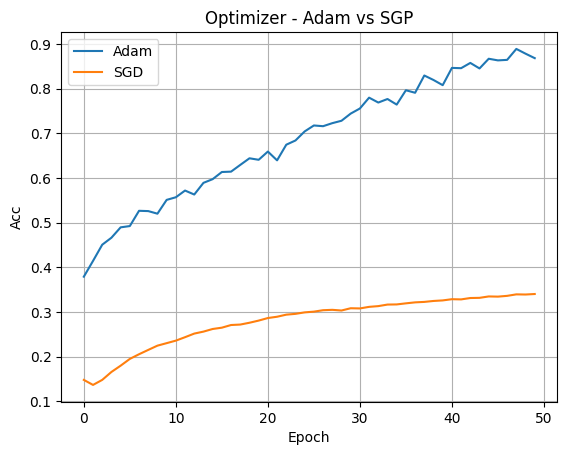

In [12]:
plot_acc(train_accs_adam, train_accs_sgd, 'Adam', 'SGD')

### Sigmoid MLP 모델 정의

In [13]:
class SigmoidMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(image.numel(), 1024)
    self.layer2 = nn.Linear(1024, 1024)
    self.layer3 = nn.Linear(1024, 10)
    self.action = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.action(self.layer1(x))
    x = self.action(self.layer2(x))
    x = self.layer3(x)

    return x


### 학습 함수 재 선언
```
상단에서 adam(), sgd() 병렬 사용을 위해 학습 함수를 따로 지정하지 않음
```

In [14]:
def train_fnc(model, opt, acc_list=[], name=''):
  model.train()
  for epoch in range(n_epochs):
    for inputs, labels in trainloader:
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()
      preds = model(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      opt.step()

    acc = accuracy(model, trainloader)
    acc_list.append(acc)
    print(f"[{name}] Epoch {epoch+1:2d} | Train Acc: {acc:.3f}")

### LeakReLU vs Sigmoid Adam optimizer 기반 성능 비교

In [15]:
model_leakyReLU = Model(image.numel(), 1024).to(device)
model_sigmoid = SigmoidMLP().to(device)

optimizer_leaky = Adam(model_leakyReLU.parameters(), lr=learning_rate)
optimizer_sigmoid = Adam(model_sigmoid.parameters(), lr=learning_rate)

train_accs_leaky = []
train_accs_sigmoid = []

### Plot 2 - 학습 실행 및 시각화

In [16]:
train_fnc(model_leakyReLU, optimizer_leaky, train_accs_leaky, name='LeakyReLU')

[LeakyReLU] Epoch  1 | Train Acc: 0.381
[LeakyReLU] Epoch  2 | Train Acc: 0.411
[LeakyReLU] Epoch  3 | Train Acc: 0.446
[LeakyReLU] Epoch  4 | Train Acc: 0.470
[LeakyReLU] Epoch  5 | Train Acc: 0.490
[LeakyReLU] Epoch  6 | Train Acc: 0.485
[LeakyReLU] Epoch  7 | Train Acc: 0.523
[LeakyReLU] Epoch  8 | Train Acc: 0.524
[LeakyReLU] Epoch  9 | Train Acc: 0.534
[LeakyReLU] Epoch 10 | Train Acc: 0.561
[LeakyReLU] Epoch 11 | Train Acc: 0.542
[LeakyReLU] Epoch 12 | Train Acc: 0.578
[LeakyReLU] Epoch 13 | Train Acc: 0.592
[LeakyReLU] Epoch 14 | Train Acc: 0.599
[LeakyReLU] Epoch 15 | Train Acc: 0.602
[LeakyReLU] Epoch 16 | Train Acc: 0.598
[LeakyReLU] Epoch 17 | Train Acc: 0.639
[LeakyReLU] Epoch 18 | Train Acc: 0.626
[LeakyReLU] Epoch 19 | Train Acc: 0.636
[LeakyReLU] Epoch 20 | Train Acc: 0.664
[LeakyReLU] Epoch 21 | Train Acc: 0.634
[LeakyReLU] Epoch 22 | Train Acc: 0.676
[LeakyReLU] Epoch 23 | Train Acc: 0.672
[LeakyReLU] Epoch 24 | Train Acc: 0.688
[LeakyReLU] Epoch 25 | Train Acc: 0.706


In [17]:
train_fnc(model_sigmoid, optimizer_sigmoid, train_accs_sigmoid, name='Sigmoid')

[Sigmoid] Epoch  1 | Train Acc: 0.324
[Sigmoid] Epoch  2 | Train Acc: 0.409
[Sigmoid] Epoch  3 | Train Acc: 0.430
[Sigmoid] Epoch  4 | Train Acc: 0.435
[Sigmoid] Epoch  5 | Train Acc: 0.451
[Sigmoid] Epoch  6 | Train Acc: 0.477
[Sigmoid] Epoch  7 | Train Acc: 0.505
[Sigmoid] Epoch  8 | Train Acc: 0.463
[Sigmoid] Epoch  9 | Train Acc: 0.502
[Sigmoid] Epoch 10 | Train Acc: 0.519
[Sigmoid] Epoch 11 | Train Acc: 0.538
[Sigmoid] Epoch 12 | Train Acc: 0.529
[Sigmoid] Epoch 13 | Train Acc: 0.553
[Sigmoid] Epoch 14 | Train Acc: 0.551
[Sigmoid] Epoch 15 | Train Acc: 0.566
[Sigmoid] Epoch 16 | Train Acc: 0.564
[Sigmoid] Epoch 17 | Train Acc: 0.574
[Sigmoid] Epoch 18 | Train Acc: 0.562
[Sigmoid] Epoch 19 | Train Acc: 0.588
[Sigmoid] Epoch 20 | Train Acc: 0.589
[Sigmoid] Epoch 21 | Train Acc: 0.591
[Sigmoid] Epoch 22 | Train Acc: 0.591
[Sigmoid] Epoch 23 | Train Acc: 0.605
[Sigmoid] Epoch 24 | Train Acc: 0.606
[Sigmoid] Epoch 25 | Train Acc: 0.615
[Sigmoid] Epoch 26 | Train Acc: 0.630
[Sigmoid] Ep

### LeakyReLU vs Sigmoid + Gradient Vanishing

**Gradient Vanishing**
- 역전파 중에 기울기가 계속 작아지다가 0에 가까워지는 현상
- 모델의 layer가 깊어질수록 심해진다
- 초기 layer로 갈수록 학습이 거의 안된다
- Sigmoid, tanh 같은 활성화함수에서 자주 발생

**ex> 5개의 layer가 존재할 때**   
``` python
output_loss   
   ↓   
layer5: ∂L/∂W5 ≈ 0.1   
   ↓   
layer4: ∂L/∂W4 ≈ 0.01   
   ↓   
layer3: ∂L/∂W3 ≈ 0.001   
   ↓   
layer2: ∂L/∂W2 ≈ 0.0001 ← gradient 거의 0 ❌   

# => 초기 레이어로 갈수록 gradient가 거의 0으로 업데이트가 안 됨
```

### Sigmoid
``` python
f(x) = 1 / (1 + e^-x)

# 위 수식을 미분하면
f'(x) = f(x) * (1 - f(x))
```
- x값이 0보다 작으면 작을수록   f'(x) = 0에 근사
- x값이 0보다 크면 클수록       f'(x) = 0에 근사

=> **이래서 Sigmoid에서 Gradient Vanishing이 발생한다**

### LeakyReLU
``` python
f(x) = x (if x > 0), αx (if x ≤ 0) # α: 고정 negative slope값

f'(x) =  1    (x > 0)  
         0.01 (x ≤ 0)
```
- x값이 0보다 크면 무조건 1
- x값이 음수면 x * negative slope로 절대 0이 되지 않음

=> **따라서 LeakReLU에서는 절대 Gradient Vanishing이 발생하지 않음**   
=> 이를 **Gradient flow가 잘 보장된다**라고 함   
=> 기울기가 잘 흘러가는 상태

### 결론
- LeakyReLU는 gradient가 0이 되지 않아 기울기가 죽지 않음
- Gradient flow가 잘 보장되는 LeakyReLU는 전체 레이어 학습이 Sigmoid보다 용이함

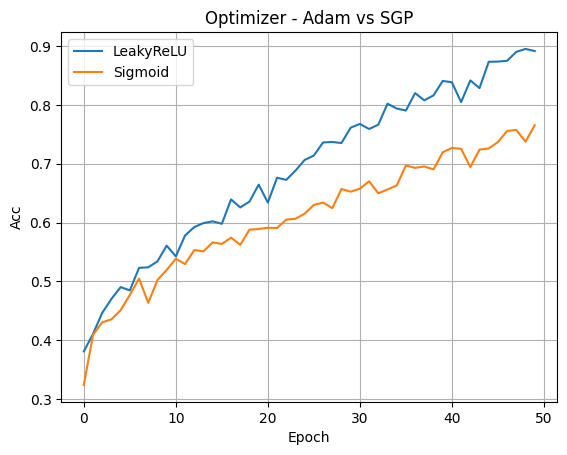

In [18]:
plot_acc(train_accs_leaky, train_accs_sigmoid, label1="LeakyReLU", label2="Sigmoid")

### Dropout 적용 모델 정의

**Dropout**
- 학습할 때 일부 뉴런을 랜덤하게 끄는 것
  - 랜덤하게 정보 흐름을 막아서 과적합을 줄임
  - 뉴런들이 서로에게 너무 의존하지 않도록 하기 위함

**필요한 이유**
- 딥러닝은 모델이 많이 복잡하기 때문에 train data에 과하게 맞춰지는 overfitting 현상이 자주 발생함
- **모든 뉴런이 항상 연결되어있으면, 특정 뉴런에만 의존할 가능성이 생김**

**Dropout 확률의 의미**
``` python
p = 0.4로 선언하면, 40% # => 보통 0.1 ~ 0.5 사용
40%의 뉴런을 매 forward 함수가 호출될 때 마다 랜덤하게 끔

# 보통 hidden layer에만 적용
[Input Layer]
   ↓
[Hidden Layer] ← 🔌 Dropout 걸림 → 랜덤하게 일부 뉴런이 꺼짐
   ↓
[Output Layer]


```

In [19]:
class DropoutMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(image.numel(), 1024)
    self.layer2 = nn.Linear(1024, 1024)
    self.layer3 = nn.Linear(1024, 10)
    self.action = nn.LeakyReLU()
    # dropout 확률 10%
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.action(self.layer1(x))
    x = self.action(self.layer2(x))
    x = self.layer3(x)

    return x

### Dropout 적용 후 train/test accuracy 측정

In [20]:
model_dropout = DropoutMLP().to(device)
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.001)

train_accs_dropout = []
test_accs_dropout = []

### 학습

In [ ]:
for epoch in range(n_epochs):
  model_dropout.train()
  for inputs, labels in trainloader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer_dropout.zero_grad()
      preds = model_dropout(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer_dropout.step()

  # 학습/테스트 정확도
  train_acc = accuracy(model_dropout, trainloader)
  test_acc = accuracy(model_dropout, testloader)

  train_accs_dropout.append(train_acc)
  test_accs_dropout.append(test_acc)

  print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

Epoch  1 | Train Acc: 0.355 | Test Acc: 0.357
Epoch  2 | Train Acc: 0.424 | Test Acc: 0.425
Epoch  3 | Train Acc: 0.456 | Test Acc: 0.452
Epoch  4 | Train Acc: 0.473 | Test Acc: 0.468
Epoch  5 | Train Acc: 0.487 | Test Acc: 0.467
Epoch  6 | Train Acc: 0.500 | Test Acc: 0.482
Epoch  7 | Train Acc: 0.519 | Test Acc: 0.490
Epoch  8 | Train Acc: 0.521 | Test Acc: 0.495
Epoch  9 | Train Acc: 0.541 | Test Acc: 0.503


### Plot 3 - Generalization 성능 시각화

In [ ]:
plot_acc(train_accs_dropout, test_accs_dropout, label1='Train', label2='Test')